# DeepAR model 

In [14]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd 
import sys, os 
import json 
import logging 
logger = logging.getLogger()

# Add folder location to Python paths so that packages can be imported 
p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
    
from src.data import open_and_transform_csv2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data transformation 

For gluonts models, the data needs to be in form of iterable objects. 

The datasets provided by GluonTS consists of three main members:
- train: iterable collection of data entries used for training. Each entry corresponds to one time series
- test: iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length. 
- metadata: contains metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc.

Moreover, gluonts use "field_names", the attributes of the type of data in the train, test and metadata. For instance train has to contain a ``target`` and a ``start`` fields for each entry, but we can add features such as ``feat_static_cat``, ``feat_static_real``, etc. The test has to contain the ``start``, ``target`` and  ``prediction_length`` fields for each entries. 


The fields are split into three categories: the required ones, the optional ones, and the ones that can be added by the Transformation (explained in a while).

#### Required:
- start: start date of the time series
- target: values of the time series

#### Optional:

- feat_static_cat: static (over time) categorical features, list with dimension equal to the number of features
- feat_static_real: static (over time) real features, list with dimension equal to the number of features
- feat_dynamic_cat: dynamic (over time) categorical features, array with shape equal to (number of features, target length)
- feat_dynamic_real: dynamic (over time) real features, array with shape equal to (number of features, target length)

#### Added by Transformation:
- time_feat: time related features such as the month or the day
- feat_dynamic_const: expands a constant value feature along the time axis
- feat_dynamic_age: age feature, i.e., a feature that its value is small for distant past timestamps and it monotonically increases the more we approach the current timestamp
- observed_values: indicator for observed values, i.e., a feature that equals to 1 if the value is observed and 0 if the value is missing
- is_pad: indicator for each time step that shows if it is padded (if the length is not enough)
- forecast_start: forecast start date

Finally, the metadata contains general information about the model. 

In [15]:
# Fieldnames are used to store data
from gluonts.dataset.field_names import FieldName
[f"FieldName.{k} = '{v}'" for k, v in FieldName.__dict__.items() if not k.startswith('_')]

["FieldName.ITEM_ID = 'item_id'",
 "FieldName.START = 'start'",
 "FieldName.TARGET = 'target'",
 "FieldName.FEAT_STATIC_CAT = 'feat_static_cat'",
 "FieldName.FEAT_STATIC_REAL = 'feat_static_real'",
 "FieldName.FEAT_DYNAMIC_CAT = 'feat_dynamic_cat'",
 "FieldName.FEAT_DYNAMIC_REAL = 'feat_dynamic_real'",
 "FieldName.FEAT_TIME = 'time_feat'",
 "FieldName.FEAT_CONST = 'feat_dynamic_const'",
 "FieldName.FEAT_AGE = 'feat_dynamic_age'",
 "FieldName.OBSERVED_VALUES = 'observed_values'",
 "FieldName.IS_PAD = 'is_pad'",
 "FieldName.FORECAST_START = 'forecast_start'"]

In [16]:
spx_daily = open_and_transform_csv2(r'../data/spx_daily.xlsx')
spx_daily.head()

,Dates,Spot t,Spot t-1,Volatility,Duration,Strike,Implied_vol,Change_in_implied_vol
0,2019-04-18,2900.45,2900.45,38.4404,6M,40,38.440400,1.641000
1,2019-04-17,2900.45,2907.06,36.7994,6M,40,36.775402,0.371102
2,2019-04-16,2907.06,2905.58,36.4043,6M,40,36.408560,0.770860
3,2019-04-15,2905.58,2907.41,35.6377,6M,40,35.632016,0.756616
4,2019-04-12,2907.41,2888.32,34.8754,6M,40,34.972001,-0.474299


In [17]:
strikes = [40,  60,  80,  90, 100, 110, 120]
maturities = ["6M", "1Y", "18M", "2Y", "3Y"]

# Start date
start = spx_daily.Dates.min()

# Organize the data as gluonts inputs 
target = []
nb_series = 0
feat_static_cat = []
feat_static_real = []
# Initialize the number of steps (this is the # of observations per TS)
num_steps =  3230

for s in strikes:
    for m in maturities: 
        df_temp = spx_daily[(spx_daily.Strike == s) & (spx_daily.Duration == m)].sort_values(by="Dates")
        if num_steps != df_temp.shape[0]: 
            print("There is a TS with different number of observations")
            break
        else: 
            target.append(df_temp.Change_in_implied_vol.values)
            nb_series += 1
            feat_static_real.append(s)
            feat_static_cat.append(m)

target, feat_static_real, feat_static_cat = np.array(target), np.array(feat_static_real), np.array(feat_static_cat)

In [18]:
# Now define the metadata containing the parameters of the dataset
metadata = {'num_series': len(strikes)*len(maturities),
                      'num_steps': num_steps,
                      'prediction_length': 10,
                      'freq': '1D',
                      'start': [pd.Timestamp(start, freq='1D')
                                for _ in range(num_steps)]
                     }

In [19]:
metadata

{'num_series': 35,
 'num_steps': 3230,
 'prediction_length': 10,
 'freq': '1D',
 'start': [Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', fr

In [20]:
# We have 35 TS, each with 3230 observations. 
# For each TS, the feat_static_real contains the strike, the feat_static_cat contains the maturity. 
print(type(target), type(feat_static_real), type(feat_static_cat))
print(target.shape, feat_static_real.shape, feat_static_cat.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(35, 3230) (35,) (35,)


In [21]:
feat_static_real, feat_static_cat

(array([ 40,  40,  40,  40,  40,  60,  60,  60,  60,  60,  80,  80,  80,
         80,  80,  90,  90,  90,  90,  90, 100, 100, 100, 100, 100, 110,
        110, 110, 110, 110, 120, 120, 120, 120, 120]),
 array(['6M', '1Y', '18M', '2Y', '3Y', '6M', '1Y', '18M', '2Y', '3Y', '6M',
        '1Y', '18M', '2Y', '3Y', '6M', '1Y', '18M', '2Y', '3Y', '6M', '1Y',
        '18M', '2Y', '3Y', '6M', '1Y', '18M', '2Y', '3Y', '6M', '1Y',
        '18M', '2Y', '3Y'], dtype='<U3'))

In [22]:
list_of_dicts = []
for ts in range(0, 35): 
    dict1 = {FieldName.TARGET: target[ts, :-metadata['prediction_length']], FieldName.START: start, FieldName.FEAT_STATIC_REAL: feat_static_real[ts]}
    list_of_dicts.append(dict1) 

In [23]:
list_of_dicts

[{'target': array([-0.01006993,  0.2887139 , -0.00359216, ...,  0.67089142,
          1.43277047, -0.6989382 ]),
  'start': Timestamp('2006-12-01 00:00:00'),
  'feat_static_real': 40},
 {'target': array([ 2.62929207, -0.83817485,  0.50118621, ...,  0.01777487,
         -0.59234985, -0.28957011]),
  'start': Timestamp('2006-12-01 00:00:00'),
  'feat_static_real': 40},
 {'target': array([ 2.64614425, -0.69361499,  0.35489715, ...,  0.17289913,
         -0.69322287,  0.09856059]),
  'start': Timestamp('2006-12-01 00:00:00'),
  'feat_static_real': 40},
 {'target': array([ 2.28578329, -0.42392183,  0.20210499, ...,  0.17556698,
         -0.55539715,  0.18650384]),
  'start': Timestamp('2006-12-01 00:00:00'),
  'feat_static_real': 40},
 {'target': array([ 1.65568673,  0.00845066, -0.04347079, ...,  0.17579733,
          0.03631044,  0.09190815]),
  'start': Timestamp('2006-12-01 00:00:00'),
  'feat_static_real': 40},
 {'target': array([ 1.62756037,  0.1772904 , -1.13956029, ...,  0.28273978,

In [11]:
from gluonts.dataset.common import ListDataset

# Create the train dataset
train_ds = ListDataset(list_of_dicts, freq=metadata['freq'])
print(train_ds)

train_entry = next(iter(train_ds))
print(f"Keys of train_ds : {train_entry.keys()}")

Keys of train_ds : dict_keys(['target', 'start', 'feat_static_real', 'source'])


In [24]:
# Creating the test dataset 
list_of_dicts = []
for ts in range(0, 35): 
    dict1 = {FieldName.TARGET: target[ts], FieldName.START: start, FieldName.FEAT_STATIC_REAL: feat_static_real[ts]}
    list_of_dicts.append(dict1) 
test_ds = ListDataset(list_of_dicts, freq=metadata['freq'])
test_ds

test_entry = next(iter(test_ds))
print(test_entry.keys())

dict_keys(['target', 'start', 'feat_static_real', 'source'])


In [25]:
from gluonts.dataset.util import to_pandas

to_pandas(train_entry)

2006-12-01   -0.010070
2006-12-02    0.288714
2006-12-03   -0.003592
2006-12-04   -0.171649
2006-12-05   -0.127384
                ...   
2015-09-20   -2.461976
2015-09-21    0.863099
2015-09-22    0.670891
2015-09-23    1.432770
2015-09-24   -0.698938
Freq: D, Length: 3220, dtype: float32

In [26]:
to_pandas(test_entry)

2006-12-01   -0.010070
2006-12-02    0.288714
2006-12-03   -0.003592
2006-12-04   -0.171649
2006-12-05   -0.127384
                ...   
2015-09-30   -0.474299
2015-10-01    0.756616
2015-10-02    0.770860
2015-10-03    0.371102
2015-10-04    1.641000
Freq: D, Length: 3230, dtype: float32

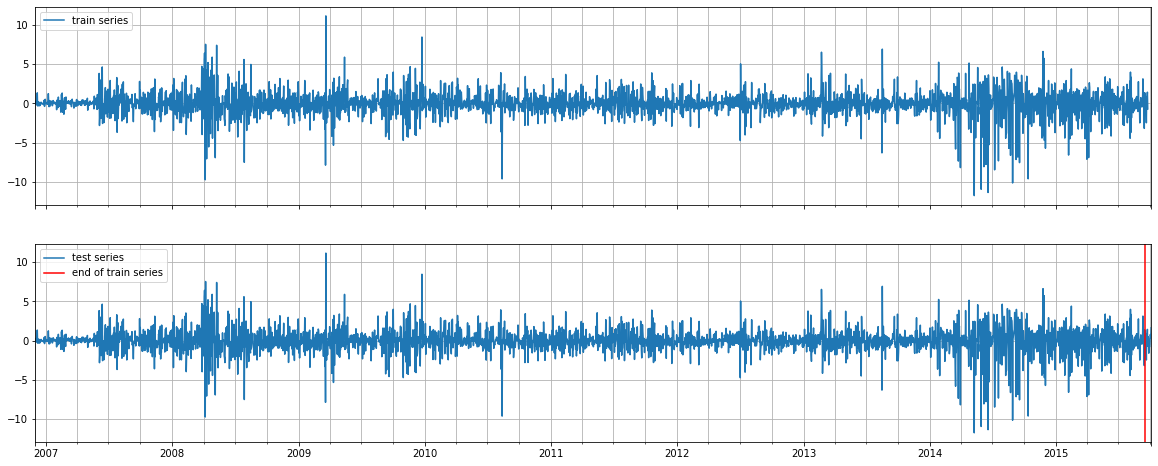

In [27]:
from gluonts.dataset.util import to_pandas
import matplotlib.pyplot as plt

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(20, 8))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-10], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [28]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {metadata['prediction_length']}")
print(f"Frequency of the time series: {metadata['freq']}")

Length of forecasting window in test dataset: 10
Recommended prediction horizon: 10
Frequency of the time series: 1D


# Models 

## 1) SimpleFeedForwardEstimator

In [49]:
metadata["num_steps"]

3230

In [157]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer

estimator1 = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[2],
    prediction_length=metadata["prediction_length"],
    context_length=150,
    freq=metadata["freq"]
    #trainer=Trainer(ctx="cpu",
    #                epochs=20,
    #                learning_rate=1e-8,
    #                num_batches_per_epoch=1
    #               )
)


In [158]:
predictor1 = estimator1.train(train_ds)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:Number of parameters in SimpleFeedForwardTrainingNetwork: 3029


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:00<00:00, 132.21it/s, avg_epoch_loss=4.44]
INFO:root:Epoch[0] Elapsed time 0.380 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=4.438805
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 147.00it/s, avg_epoch_loss=3.64]
INFO:root:Epoch[1] Elapsed time 0.342 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=3.635443
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 166.05it/s, avg_epoch_loss=2.87]
INFO:root:Epoch[2] Elapsed time 0.308 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=2.873528
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 149.49it/s, avg_epoch_loss=2.36]
INFO:root:Epoch[3] Elapsed time 0.359 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=2.364684
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 138.01it/s, avg_epoch_loss=1.98]
INFO:root:Epoch[4] Elapsed time 0.373 seconds
INFO:root:Epoch[

100%|██████████| 50/50 [00:00<00:00, 181.93it/s, avg_epoch_loss=0.439]
INFO:root:Epoch[37] Elapsed time 0.276 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.439345
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 174.26it/s, avg_epoch_loss=0.384]
INFO:root:Epoch[38] Elapsed time 0.289 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.384197
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 184.27it/s, avg_epoch_loss=0.406]
INFO:root:Epoch[39] Elapsed time 0.273 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.405602
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 175.89it/s, avg_epoch_loss=0.443]
INFO:root:Epoch[40] Elapsed time 0.286 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=0.442524
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 182.53it/s, avg_epoch_loss=0.397]
INFO:root:Epoch[41] Elapsed time 0.276 second

100%|██████████| 50/50 [00:00<00:00, 185.08it/s, avg_epoch_loss=0.4]
INFO:root:Epoch[73] Elapsed time 0.273 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.400285
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 178.66it/s, avg_epoch_loss=0.393]
INFO:root:Epoch[74] Elapsed time 0.282 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.393186
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 167.35it/s, avg_epoch_loss=0.387]
INFO:root:Epoch[75] Elapsed time 0.300 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.387195
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 186.49it/s, avg_epoch_loss=0.38]
INFO:root:Epoch[76] Elapsed time 0.270 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=0.379580
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 181.75it/s, avg_epoch_loss=0.377]
INFO:root:Epoch[77] Elapsed time 0.2

In [159]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,       # test dataset
    predictor=predictor1,  # predictor
    num_samples=100,       # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

ts_entry = tss[0]
np.array(ts_entry[:5]).reshape(-1,)

array([-0.01006993,  0.2887139 , -0.00359216, -0.17164895, -0.12738441],
      dtype=float32)

In [160]:
dataset_test_entry = next(iter(test_ds))
dataset_test_entry['target'][:5]

array([-0.01006993,  0.2887139 , -0.00359216, -0.17164895, -0.12738441],
      dtype=float32)

In [161]:
# first entry of the forecast list
forecast_entry = forecasts[0]
forecast_entry

gluonts.model.forecast.SampleForecast(freq="1D", info=None, item_id=None, samples=numpy.array([[1.393614649772644, -0.1685086041688919, -0.5217299461364746, 0.9792105555534363, -0.3938627243041992, 0.1688816100358963, -0.024914056062698364, 1.7889699935913086, -1.3902883529663086, -3.351623058319092], [0.5275322794914246, -1.13713538646698, 0.15349191427230835, -0.32265612483024597, -1.9221082925796509, -1.3478748798370361, 0.2847346067428589, -2.320669412612915, -0.3149236738681793, 0.031067918986082077], [0.9267789721488953, 0.2883060872554779, 1.2171496152877808, -0.94527268409729, 0.3649362623691559, -0.0939440205693245, -2.5092923641204834, 1.4721014499664307, 0.34787946939468384, -1.3151671886444092], [-0.30149537324905396, -4.300097942352295, -0.16621212661266327, 0.6956064701080322, -0.5240616202354431, -1.291276216506958, 0.4962334632873535, -0.2218456268310547, -1.8395934104919434, 0.4178215563297272], [-1.7435356378555298, 0.3455001711845398, 1.388479232788086, 1.95323801040

In [162]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 50
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

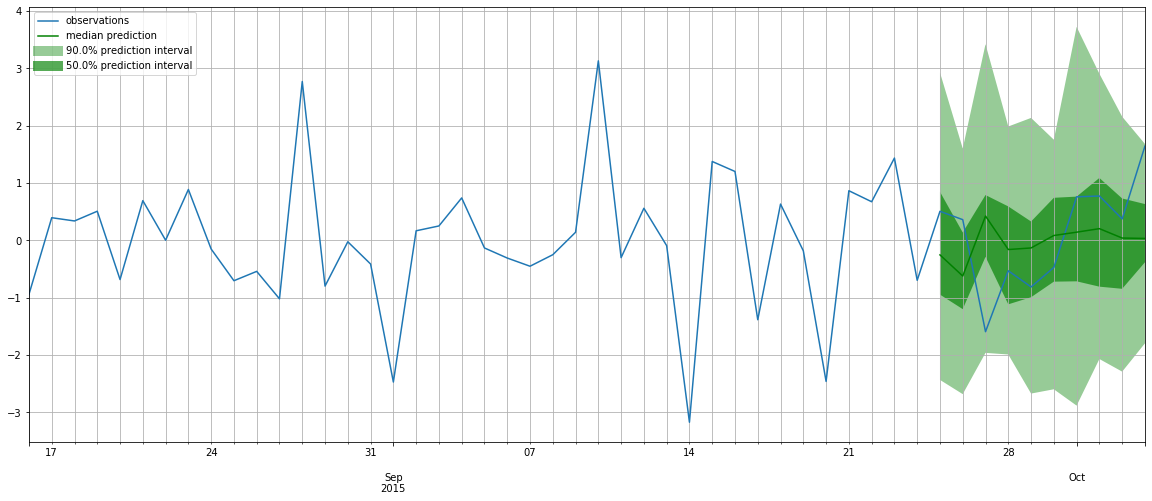

In [163]:
plot_prob_forecasts(ts_entry, forecast_entry)

In [164]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 35/35 [00:00<00:00, 106.53it/s]

{
    "MSE": 0.05499430676123925,
    "abs_error": 47.306845903396606,
    "abs_target_sum": 46.50779569149017,
    "abs_target_mean": 0.1328794162614005,
    "seasonal_error": 0.4787515084213292,
    "MASE": 0.2526276764926692,
    "sMAPE": 1.4762418123746124,
    "MSIS": 1.7923575468239445,
    "QuantileLoss[0.1]": 26.764290925860408,
    "Coverage[0.1]": 0.042857142857142864,
    "QuantileLoss[0.5]": 47.30684489151463,
    "Coverage[0.5]": 0.5000000000000001,
    "QuantileLoss[0.9]": 25.24848812371492,
    "Coverage[0.9]": 0.9714285714285714,
    "RMSE": 0.23450864965122128,
    "NRMSE": 1.7648229970388767,
    "ND": 1.017180995143415,
    "wQuantileLoss[0.1]": 0.5754796701912415,
    "wQuantileLoss[0.5]": 1.0171809733861599,
    "wQuantileLoss[0.9]": 0.542887224567704,
    "mean_wQuantileLoss": 0.7118492893817018,
    "MAE_Coverage": 0.04285714285714288
}


## 2) DeepAR

In [123]:
from gluonts.model.deepar import DeepAREstimator

estimator = DeepAREstimator(
    prediction_length=metadata["prediction_length"],
    context_length=150,
    freq=metadata["freq"], 
    trainer=Trainer(ctx="cpu",
                epochs=50,
                learning_rate=1e-10,
                num_batches_per_epoch=3
               )
)

In [124]:
predictor = estimator.train(train_ds)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 1e-10
  0%|          | 0/3 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:root:Number of parameters in DeepARTrainingNetwork: 25884
100%|██████████| 3/3 [00:01<00:00,  1.84it/s, avg_epoch_loss=0.427]
INFO:root:Epoch[0] Elapsed time 1.639 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.427272
INFO:root:Epoch[1] Learning rate is 1e-10
100%|██████████| 3/3 [00:00<00:00,  4.83it/s, avg_epoch_loss=0.419]
INFO:root:Epoch[1] Elapsed time 0.623 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.419049
INFO:root:Epoch[2] Learning rate is 1e-10
100%|██████████| 3/3 [00:00<00:00,  4.87it/s, avg_epoch_loss=0.403]
INFO:root:Epoch[2] Elapsed time 0.621 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.402753
INFO:root:Epoch[3] Learning rate is 1e-10
100%|██████████| 3/3 [00:00<00:00,  5.18it/s, avg_epoch_loss=0.501]
INFO:root:Epoch[3] Elapsed time 0.584 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.500705
INFO:root:Epoch[4] Learning rate is 1e-10
100%|██████████| 3/3 [00:00<00:00,  5.07it/s, avg_epoch_loss=0.294]
INFO:root

100%|██████████| 3/3 [00:00<00:00,  5.20it/s, avg_epoch_loss=0.367]
INFO:root:Epoch[37] Elapsed time 0.579 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.367450
INFO:root:Epoch[38] Learning rate is 5e-05
100%|██████████| 3/3 [00:00<00:00,  5.16it/s, avg_epoch_loss=0.5]
INFO:root:Epoch[38] Elapsed time 0.583 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.499802
INFO:root:Epoch[39] Learning rate is 5e-05
100%|██████████| 3/3 [00:00<00:00,  5.21it/s, avg_epoch_loss=0.338]
INFO:root:Epoch[39] Elapsed time 0.577 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.338319
INFO:root:Epoch[40] Learning rate is 5e-05
100%|██████████| 3/3 [00:00<00:00,  5.24it/s, avg_epoch_loss=0.399]
INFO:root:Epoch[40] Elapsed time 0.575 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=0.398808
INFO:root:Epoch[41] Learning rate is 5e-05
100%|██████████| 3/3 [00:00<00:00,  5.19it/s, avg_epoch_loss=0.413]
INFO:root:Epoch[41] Elapsed time 0.581 seconds
INFO:root:Epoch

In [125]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,      # test dataset
    predictor=predictor,  # predictor
    num_samples=100,      # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

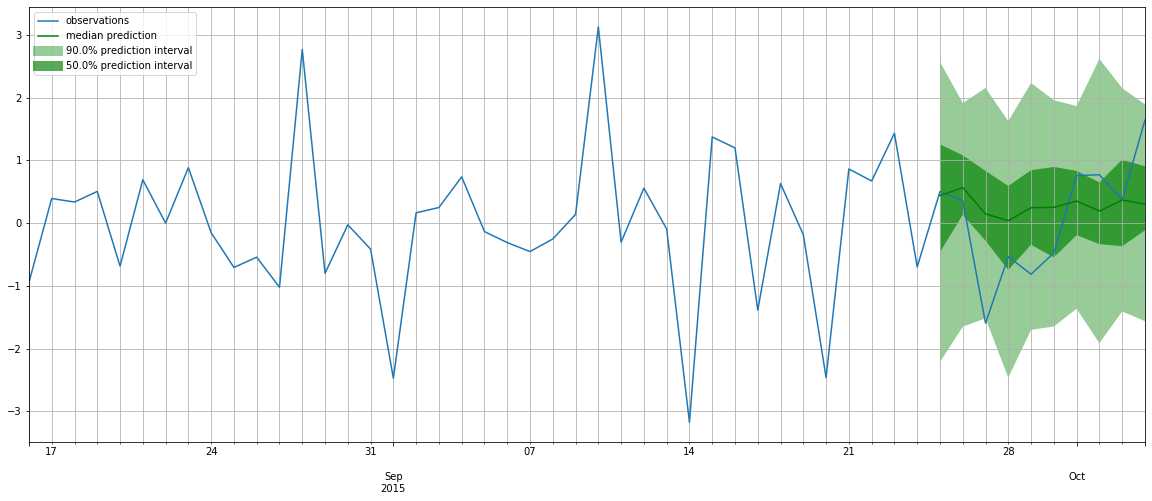

In [126]:
forecast_entry = forecasts[0]

plot_prob_forecasts(ts_entry, forecast_entry)

In [127]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 35/35 [00:00<00:00, 140.01it/s]


In [128]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.061608425091419915,
    "abs_error": 48.8012261390686,
    "abs_target_sum": 46.50779569149017,
    "abs_target_mean": 0.1328794162614005,
    "seasonal_error": 0.4787515084213292,
    "MASE": 0.26827996647580155,
    "sMAPE": 1.352759642958429,
    "MSIS": 2.220145916126671,
    "QuantileLoss[0.1]": 25.69153198003769,
    "Coverage[0.1]": 0.09714285714285716,
    "QuantileLoss[0.5]": 48.80122564570047,
    "Coverage[0.5]": 0.66,
    "QuantileLoss[0.9]": 25.261154730617996,
    "Coverage[0.9]": 0.977142857142857,
    "RMSE": 0.24821044516985968,
    "NRMSE": 1.8679375041923714,
    "ND": 1.04931281763582,
    "wQuantileLoss[0.1]": 0.5524134523696344,
    "wQuantileLoss[0.5]": 1.049312807027531,
    "wQuantileLoss[0.9]": 0.5431595790561234,
    "mean_wQuantileLoss": 0.7149619461510962,
    "MAE_Coverage": 0.07999999999999995
}


### Second DeepAR model 

In [131]:
estimator2 = DeepAREstimator(
    prediction_length=metadata["prediction_length"],
    context_length=100,
    freq=metadata["freq"]
)

predictor2 = estimator2.train(train_ds)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:root:Number of parameters in DeepARTrainingNetwork: 25884
100%|██████████| 50/50 [00:07<00:00,  6.85it/s, avg_epoch_loss=0.323]
INFO:root:Epoch[0] Elapsed time 7.305 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.323018
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:07<00:00,  7.13it/s, avg_epoch_loss=0.279]
INFO:root:Epoch[1] Elapsed time 7.015 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.278881
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:06<00:00,  7.45it/s, avg_epoch_loss=0.243]
INFO:root:Epoch[2] Elapsed time 6.719 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.242526
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:06<00:00,  7.40it/s, avg_epoch_loss=0.229]
INFO:root:Epoch[3] Elapsed time 6.758 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.229187
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:06<00:00,  7.40it/s, avg_epoch_loss=0.14]


100%|██████████| 50/50 [00:07<00:00,  6.69it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[37] Elapsed time 7.477 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.139472
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:07<00:00,  6.97it/s, avg_epoch_loss=-.136]
INFO:root:Epoch[38] Elapsed time 7.178 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.136030
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:07<00:00,  6.67it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[39] Elapsed time 7.499 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.158035
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:07<00:00,  6.83it/s, avg_epoch_loss=-.124]
INFO:root:Epoch[40] Elapsed time 7.326 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-0.123738
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:06<00:00,  7.30it/s, avg_epoch_loss=-.184]
INFO:root:Epoch[41] Elapsed time 6.856 seconds

100%|██████████| 50/50 [00:06<00:00,  7.32it/s, avg_epoch_loss=-.237]
INFO:root:Epoch[74] Elapsed time 6.833 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-0.236802
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 50/50 [00:06<00:00,  7.31it/s, avg_epoch_loss=-.233]
INFO:root:Epoch[75] Elapsed time 6.841 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.232504
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 50/50 [00:06<00:00,  7.33it/s, avg_epoch_loss=-.258]
INFO:root:Epoch[76] Elapsed time 6.826 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-0.257589
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 50/50 [00:06<00:00,  7.36it/s, avg_epoch_loss=-.284]
INFO:root:Epoch[77] Elapsed time 6.793 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=-0.284240
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 50/50 [00:06<00:00,  7.43it/s, avg_epoch_loss=-.269]
INFO:root:Epoch[78] Elapsed time 6.731 seconds

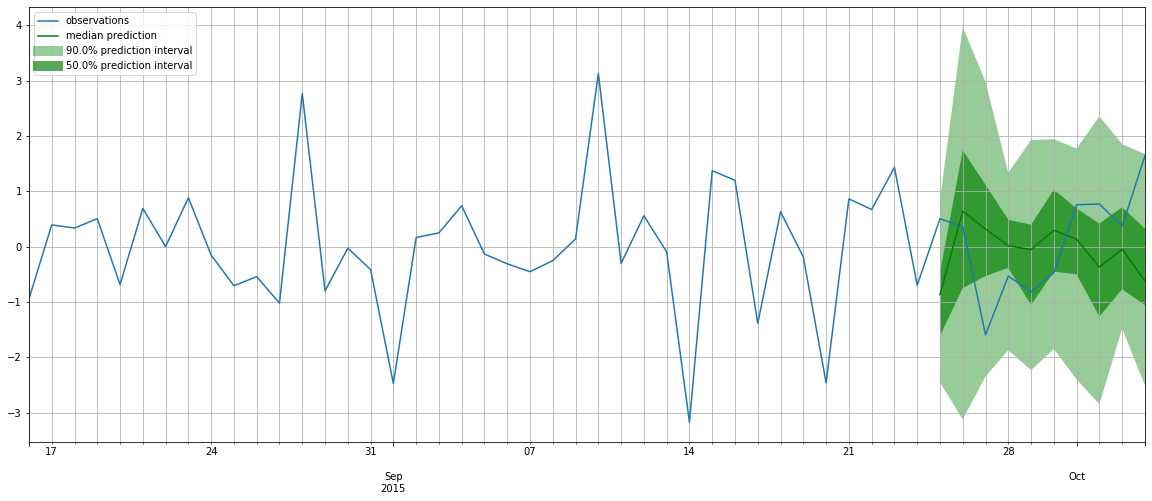

In [136]:
forecast_it2, ts_it2 = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor2,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts2 = list(forecast_it2)
tss2 = list(ts_it2)

forecast_entry2 = forecasts2[0]

plot_prob_forecasts(ts_entry, forecast_entry2)

In [138]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss2), iter(forecasts2), num_series=len(test_ds))

print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 35/35 [00:00<00:00, 128.52it/s]

{
    "MSE": 0.08114973034177506,
    "abs_error": 59.11790198087692,
    "abs_target_sum": 46.50779569149017,
    "abs_target_mean": 0.1328794162614005,
    "seasonal_error": 0.4787515084213292,
    "MASE": 0.32088824740400557,
    "sMAPE": 1.4792748606751602,
    "MSIS": 2.5724530562311396,
    "QuantileLoss[0.1]": 28.5585021847859,
    "Coverage[0.1]": 0.1457142857142857,
    "QuantileLoss[0.5]": 59.11790253804065,
    "Coverage[0.5]": 0.5714285714285714,
    "QuantileLoss[0.9]": 24.851709138602015,
    "Coverage[0.9]": 0.9571428571428572,
    "RMSE": 0.2848679173613186,
    "NRMSE": 2.143807712105885,
    "ND": 1.2711396251294296,
    "wQuantileLoss[0.1]": 0.6140583908605118,
    "wQuantileLoss[0.5]": 1.271139637109437,
    "wQuantileLoss[0.9]": 0.5343557734590567,
    "mean_wQuantileLoss": 0.8065179338096685,
    "MAE_Coverage": 0.05809523809523809
}
